Author: Minh Le

Institution: Luther College

# Loading dataset and libraries




In [ ]:
! pip install -q kaggle
from google.colab import files
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download imdevskp/corona-virus-report

100% 19.0M/19.0M [00:00<00:00, 196MB/s]
100% 19.0M/19.0M [00:00<00:00, 195MB/s]


In [ ]:
! mkdir /content/dataset
! mv /content/corona-virus-report.zip /content/dataset

In [ ]:
!unzip /content/dataset/corona-virus-report.zip -d /content/dataset/
!rm /content/dataset/corona-virus-report.zip

Archive:  /content/dataset/corona-virus-report.zip
  inflating: /content/dataset/country_wise_latest.csv  
  inflating: /content/dataset/covid_19_clean_complete.csv  
  inflating: /content/dataset/day_wise.csv  
  inflating: /content/dataset/full_grouped.csv  
  inflating: /content/dataset/usa_county_wise.csv  
  inflating: /content/dataset/worldometer_data.csv  


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

import statsmodels as sm
from statsmodels.tsa.arima.model import ARIMA
from math import sqrt

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
data=pd.read_csv("/content/dataset/covid_19_clean_complete.csv")

In [ ]:
data.head(10)

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,WHO Region
0,NaN,Afghanistan,33.93911,67.709953,2020-01-22,0,0,0,0,Eastern Mediterranean
1,NaN,Albania,41.15330,20.168300,2020-01-22,0,0,0,0,Europe
2,NaN,Algeria,28.03390,1.659600,2020-01-22,0,0,0,0,Africa
3,NaN,Andorra,42.50630,1.521800,2020-01-22,0,0,0,0,Europe
4,NaN,Angola,-11.20270,17.873900,2020-01-22,0,0,0,0,Africa
5,NaN,Antigua and Barbuda,17.06080,-61.796400,2020-01-22,0,0,0,0,Americas
6,NaN,Argentina,-38.41610,-63.616700,2020-01-22,0,0,0,0,Americas
7,NaN,Armenia,40.06910,45.038200,2020-01-22,0,0,0,0,Europe
8,Australian Capital Territory,Australia,-35.47350,149.012400,2020-01-22,0,0,0,0,Western Pacific
9,New South Wales,Australia,-33.86880,151.209300,2020-01-22,0,0,0,0,Western Pacific


In [ ]:
files=[]
names=[]
from pathlib import Path
data_dir = Path('/content/dataset')

import os
os.listdir(data_dir)
for i in os.listdir(data_dir):
  files.append(i)
  names.append(i[:-4])
print(names)
print(files)
for i in range(len(names)):
  try: exec(f"data_{names[i]} = pd.read_csv(data_dir/files[i], parse_dates=['Date'])")
  except: exec(f"data_{names[i]} = pd.read_csv(data_dir/files[i])")
for i in names:
  exec(f"cols_to_convert = data_{i}.select_dtypes(include='object').columns")
  exec(f"data_{i}[cols_to_convert]=data_{i}[cols_to_convert].astype('category')")

#special cases:
# TERM NOTATIONS:
# 1/ FIPS: FIPS codes, when referring to U.S. states and territories, are unique two-digit codes assigned to each state and territory for identification purposes. For Guam, the FIPS code is "66".
# 2/ iso2: ISO 3166-1 alpha-2 (often referred to as ISO2): This is a two-letter code that represents countries
# 3/ iso3: ISO 3166-1 alpha-3 (often referred to as ISO3): This is a three-letter code for countries
# 4/ code3: ISO 3166-1 numeric (or numeric-3) codes are three-digit numbers used to represent countries and areas
# 5/ UID: a numeric or alphanumeric string that is associated with a single entity within a given system

data_usa_county_wise["UID"] = data_usa_county_wise["UID"].astype('category')
data_usa_county_wise["code3"] = data_usa_county_wise["code3"].astype('category')
data_usa_county_wise["FIPS"] = data_usa_county_wise["FIPS"].astype('category')

['covid_19_clean_complete', 'worldometer_data', 'day_wise', 'country_wise_latest', 'usa_county_wise', 'full_grouped']
['covid_19_clean_complete.csv', 'worldometer_data.csv', 'day_wise.csv', 'country_wise_latest.csv', 'usa_county_wise.csv', 'full_grouped.csv']


## changing df into time-series data by regions


In [ ]:
asia_regions = {
    "Central_Asia": ["Kazakhstan", "Uzbekistan", "Turkmenistan", "Kyrgyzstan", "Tajikistan"],
    "East_Asia": ["China", "Japan", "South Korea", "North Korea", "Mongolia"],
    "South_Asia": ["Afghanistan", "India", "Pakistan", "Bangladesh", "Sri Lanka", "Nepal", "Bhutan", "Maldives"],
    "Southeast_Asia": ["Indonesia", "Malaysia", "Singapore", "Thailand", "Vietnam", "Cambodia", "Myanmar", "Laos", "Philippines", "Brunei", "Timor-Leste", "Burma"],
    "West_Asia": ["Saudi Arabia", "Turkey", "Iran", "Iraq", "Israel", "Jordan", "Lebanon", "Syria", "Cyprus", "Palestine", "Kuwait", "Bahrain", "Qatar", "United Arab Emirates", "Oman", "Yemen", "Armenia", "Azerbaijan", "Georgia"]

}

In [ ]:
for region in asia_regions:
      if region in data_covid_19_clean_complete['WHO Region'].cat.categories:

        data_covid_19_clean_complete['WHO Region'] = data_covid_19_clean_complete['WHO Region'].replace(region, region)

      #data_covid_19_clean_complete['WHO Region'] = data_covid_19_clean_complete['WHO Region'].cat.remove_categories(region)

      data_covid_19_clean_complete['WHO Region'] = data_covid_19_clean_complete['WHO Region'].cat.add_categories(region)
      for country in asia_regions[region]:
        data_covid_19_clean_complete.loc[data_covid_19_clean_complete['Country/Region'] == country, 'WHO Region'] = region

In [ ]:
data_covid_19_clean_complete.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,WHO Region
0,NaN,Afghanistan,33.93911,67.709953,2020-01-22,0,0,0,0,South_Asia
1,NaN,Albania,41.15330,20.168300,2020-01-22,0,0,0,0,Europe
2,NaN,Algeria,28.03390,1.659600,2020-01-22,0,0,0,0,Africa
3,NaN,Andorra,42.50630,1.521800,2020-01-22,0,0,0,0,Europe
4,NaN,Angola,-11.20270,17.873900,2020-01-22,0,0,0,0,Africa


In [ ]:
import pandas as pd

# Define a dictionary to store the region-specific DataFrames
region_dataframes = {}

# Define the columns to aggregate
columns_to_aggregate = ['Confirmed', 'Deaths', 'Recovered', 'Active']

# Iterate through the regions
for region, countries in asia_regions.items():
    # Filter the data for countries in the current region
    region_data = data_covid_19_clean_complete[data_covid_19_clean_complete['Country/Region'].isin(countries)]

    # Group the data by Date and sum the values for all countries in the current region, filling NaN values with 0
    region_aggregated = region_data.groupby('Date')[columns_to_aggregate].sum().fillna(0).reset_index()

    # Add a new column with the region name
    region_aggregated['WHO Region'] = region

    # Create a variable with the naming convention "data_[region_name]"
    globals()[f"data_{region.replace(' ', '_')}"] = pd.DataFrame(region_aggregated)

# Display the separate DataFrames
print("Data for Central Asia:")
print(data_Central_Asia)

# You can access other region-specific DataFrames in a similar way.


Data for Central Asia:
          Date  Confirmed  Deaths  Recovered  Active    WHO Region
0   2020-01-22          0       0          0       0  Central_Asia
1   2020-01-23          0       0          0       0  Central_Asia
2   2020-01-24          0       0          0       0  Central_Asia
3   2020-01-25          0       0          0       0  Central_Asia
4   2020-01-26          0       0          0       0  Central_Asia
..         ...        ...     ...        ...     ...           ...
183 2020-07-23     135779    1957      83468   50354  Central_Asia
184 2020-07-24     137937    1960      85621   50356  Central_Asia
185 2020-07-25     140946    2004      87763   51179  Central_Asia
186 2020-07-26     143658    2037      90034   51587  Central_Asia
187 2020-07-27     146388    2067      93311   51010  Central_Asia

[188 rows x 6 columns]


## train_test split for ARIMA by Asian Regions




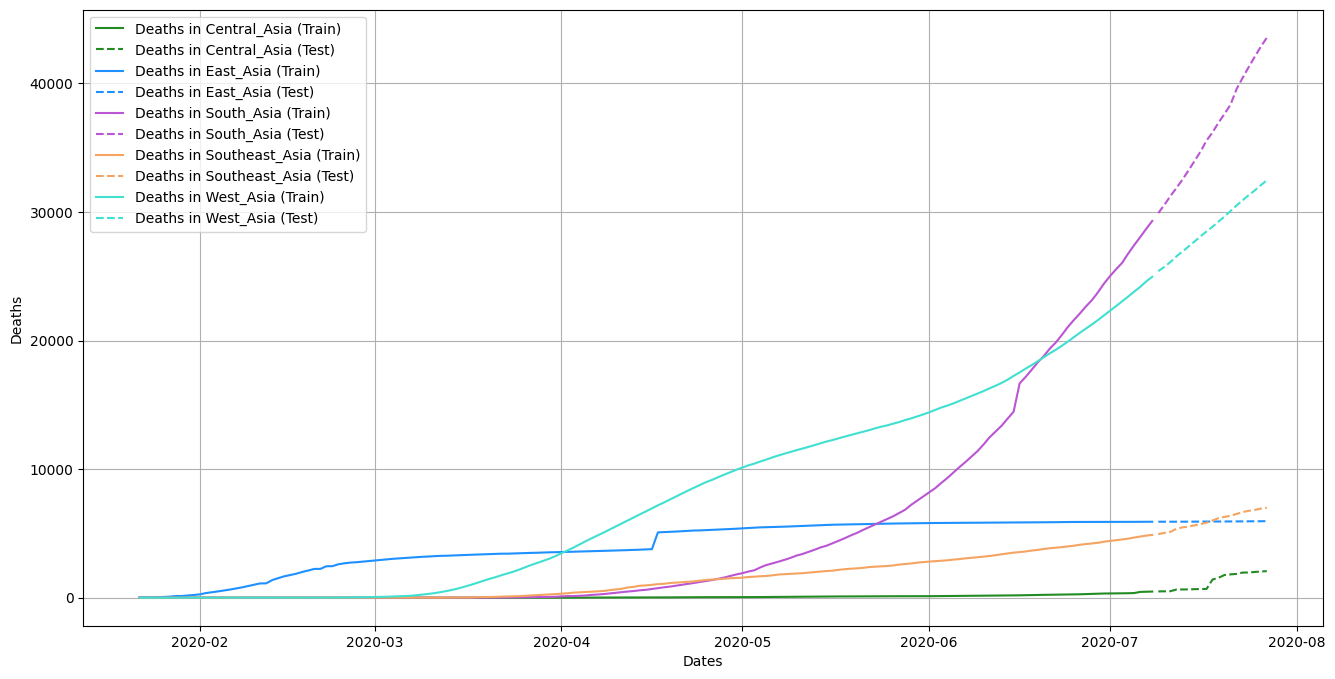

In [ ]:
colors = ['forestgreen', 'dodgerblue', 'mediumorchid', 'sandybrown', 'turquoise']


plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Deaths')


for region,color in zip(asia_regions.keys(),colors):
  exec(f"train_{region},test_{region}=data_{region}[0:int(len(data_{region})*0.9)], data_{region}[int(len(data_{region})*0.9):]")

  # Plot the training data
  exec(f"plt.plot(train_{region}['Date'], train_{region}['Deaths'], label=f'Deaths in {region} (Train)', color=color)")

  # Plot the test data
  exec(f"plt.plot(test_{region}['Date'], test_{region}['Deaths'], label=f'Deaths in {region} (Test)', linestyle='dashed', color=color)")

# Add a legend to distinguish regions
plt.legend()

# Display the plot
plt.show()


# ARIMA future predictions (60 days)

## pacf & acf

We plot the pacf (pacf) and acf (autocorrelation) indexes to determine the parameters (p,d,q) for ARIMA model

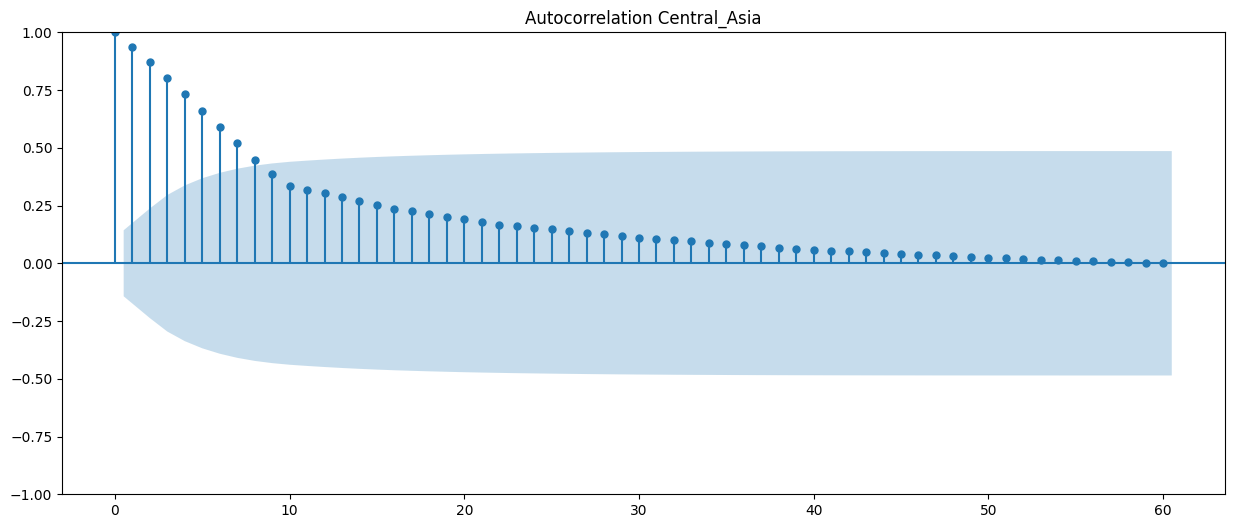

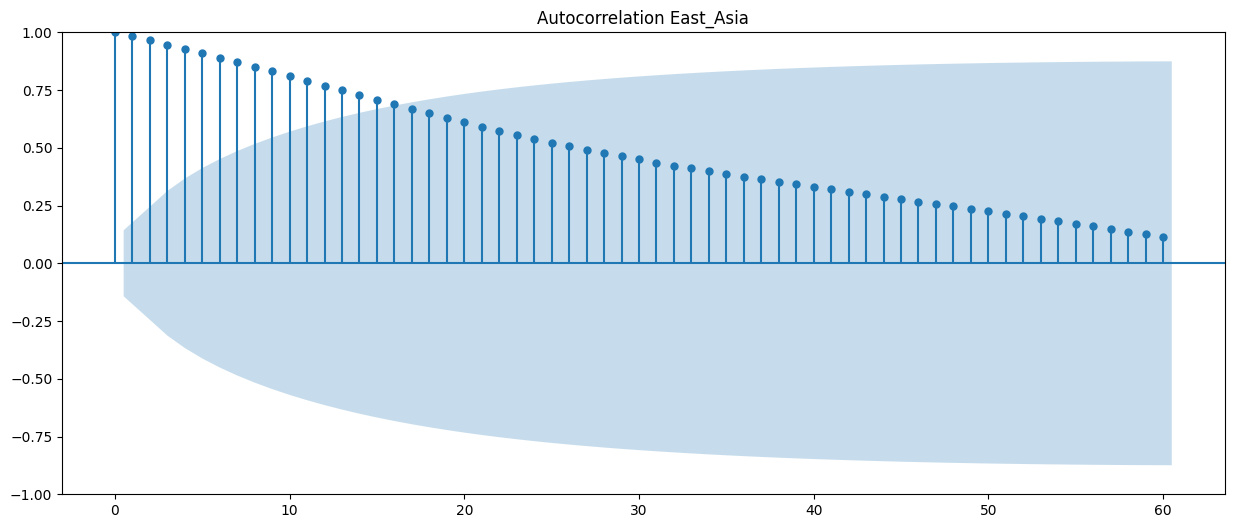

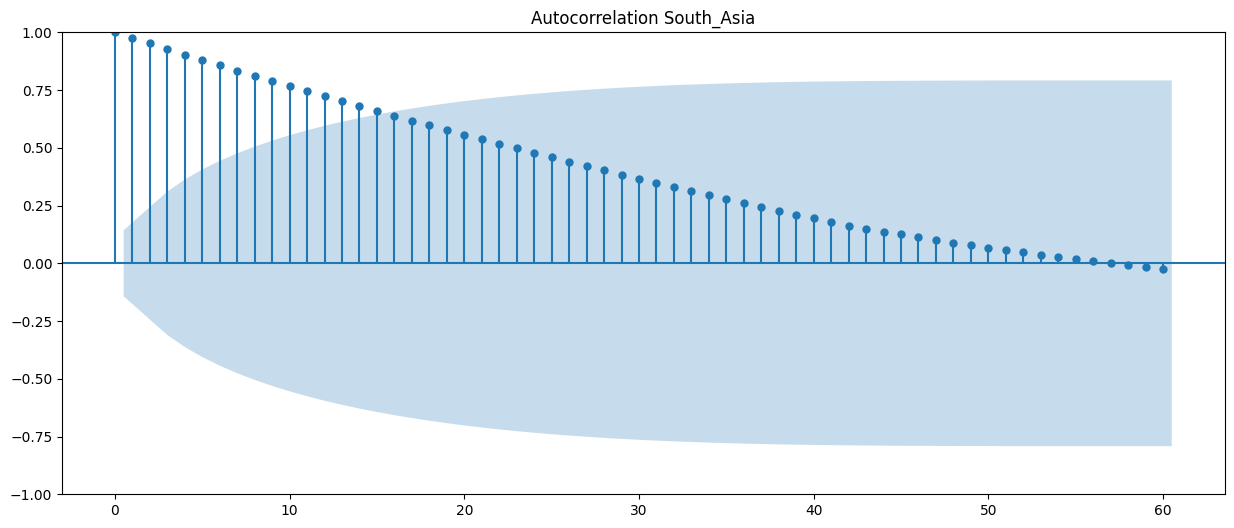

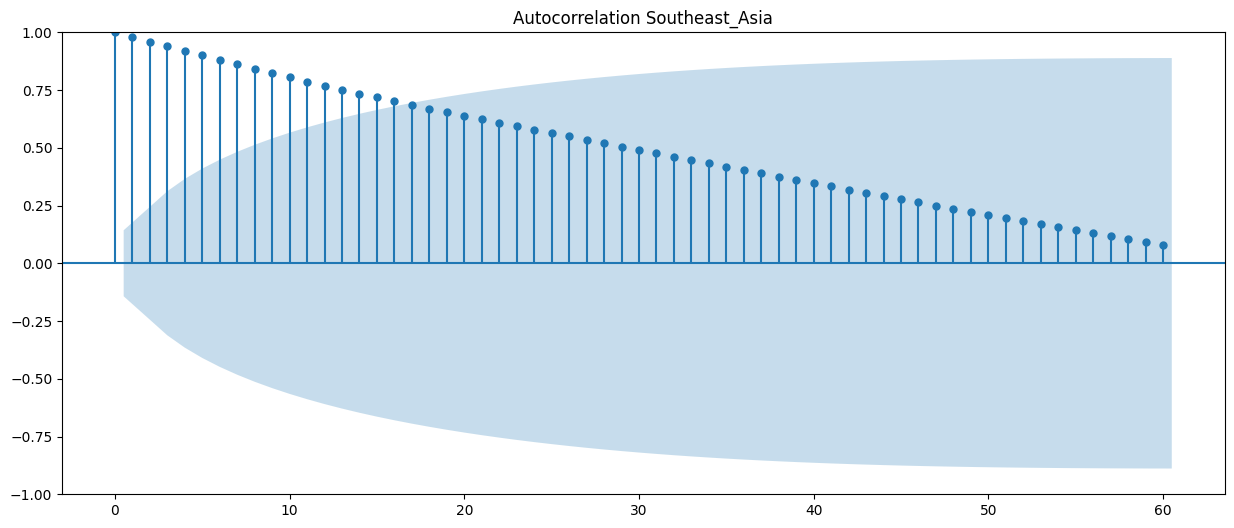

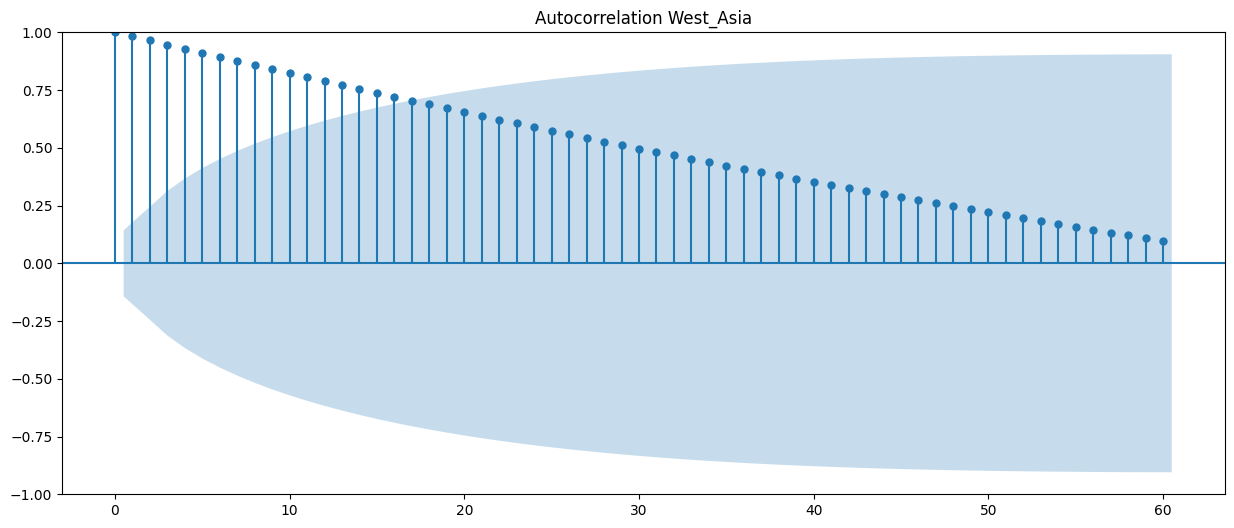

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm


for region in asia_regions.keys():
  exec(f'sm.graphics.tsa.plot_acf(data_{region}["Deaths"], lags=60)')
  plt.title(f"Autocorrelation {region}")
  plt.show()


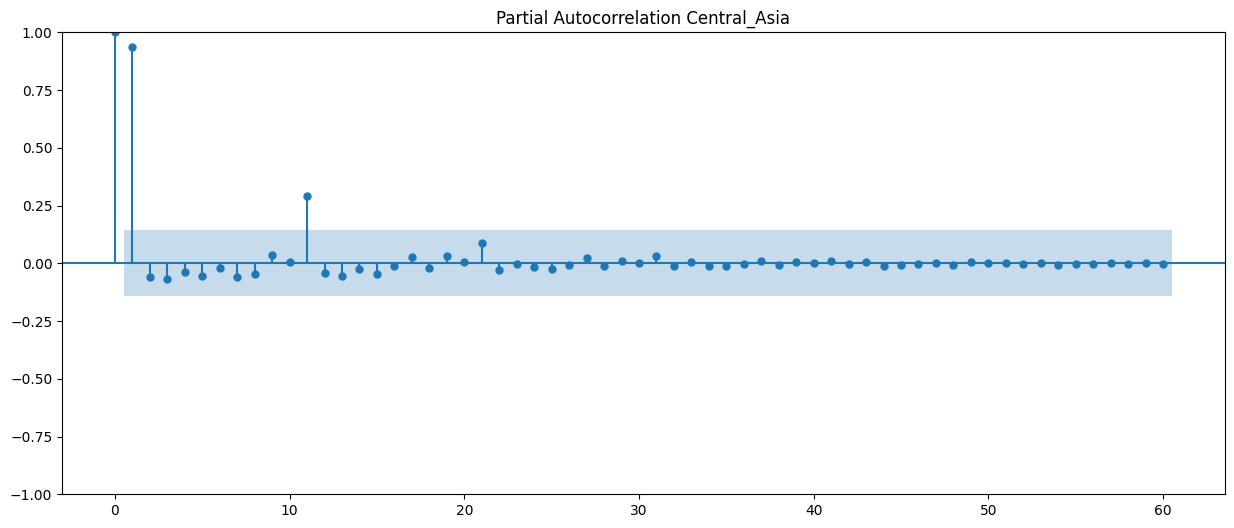

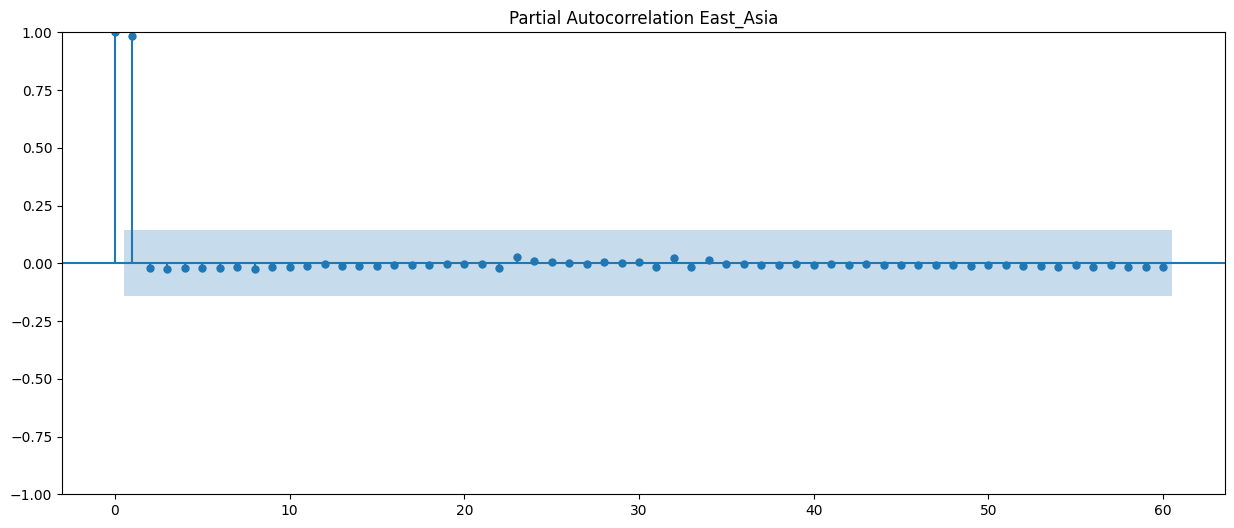

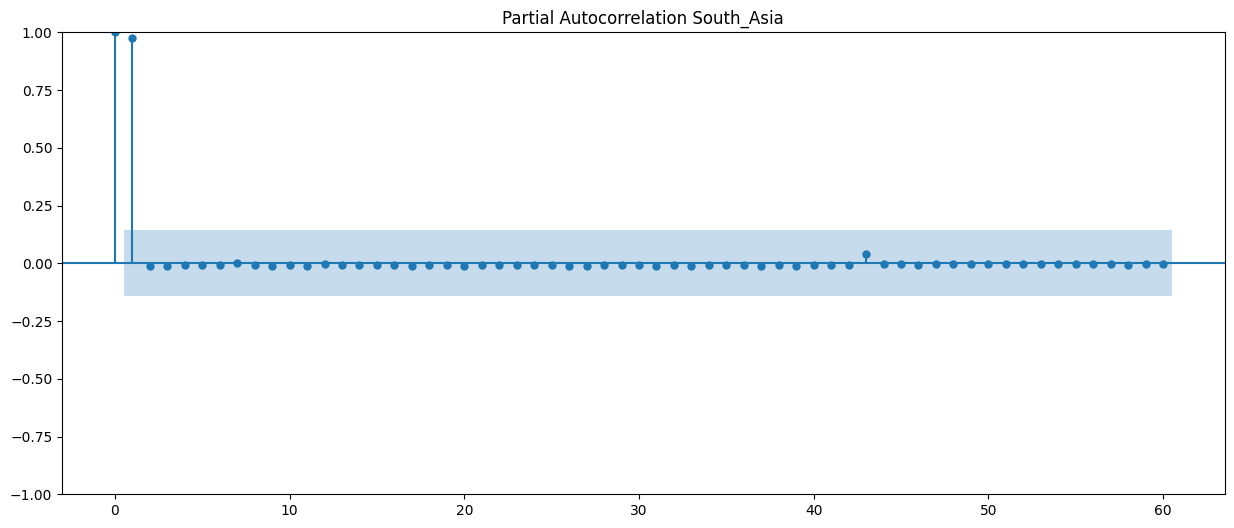

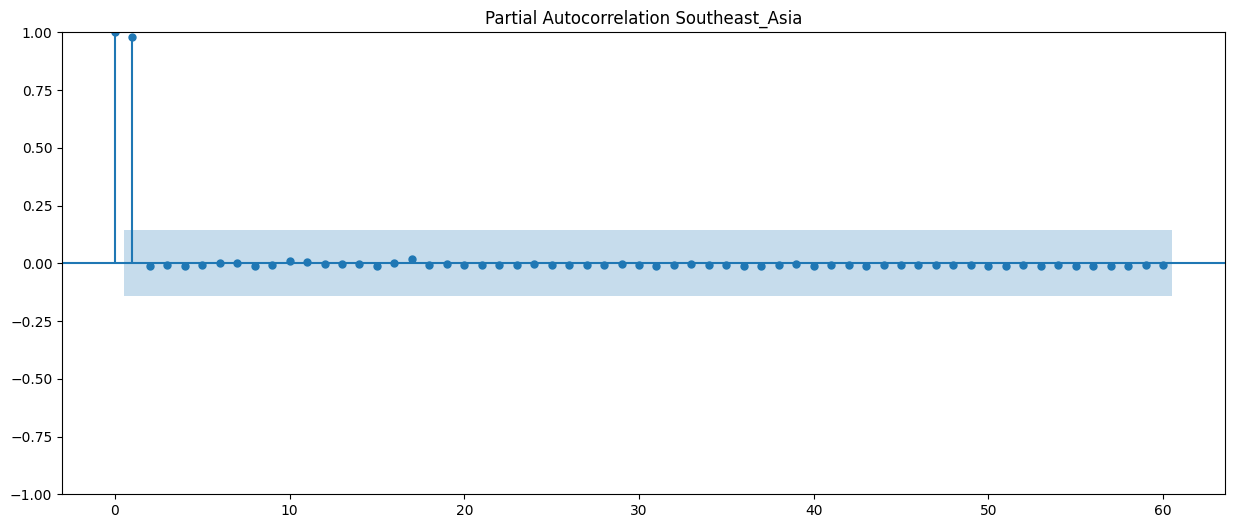

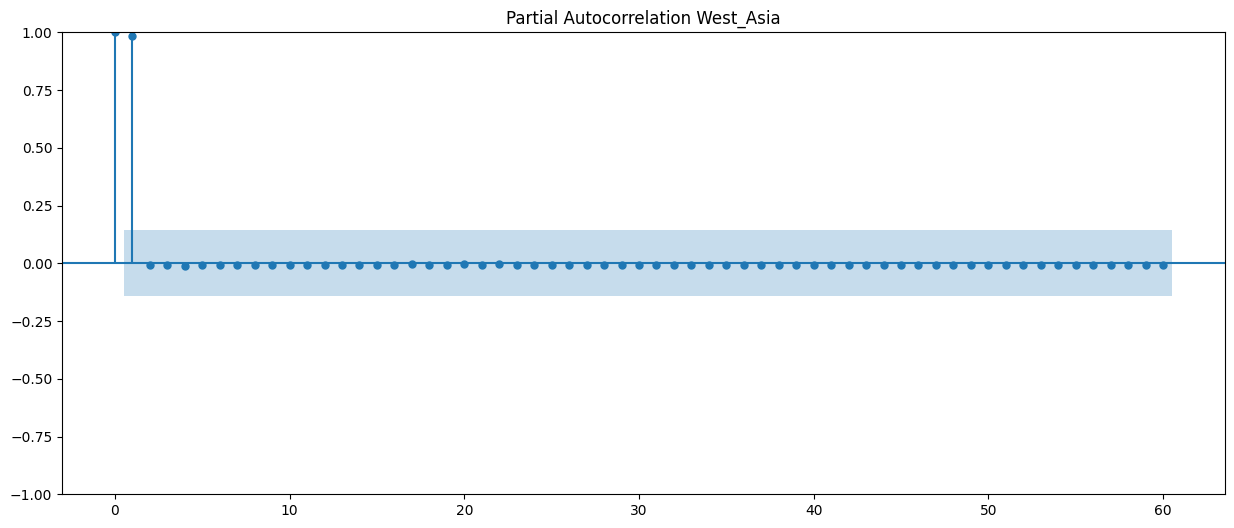

In [ ]:

for region in asia_regions.keys():
  exec(f'sm.graphics.tsa.plot_pacf(data_{region}["Deaths"], lags=60, method="ywm")')
  plt.title(f"Partial Autocorrelation {region}")
  plt.show()

# print(data_Central_Asia)


Through the graphs, we saw a continuos decline in pacf, and a lag period of 2 days in acf, therefore, the parameters for ARIMA model would be (2,1,0)

## ARIMA for Deaths

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


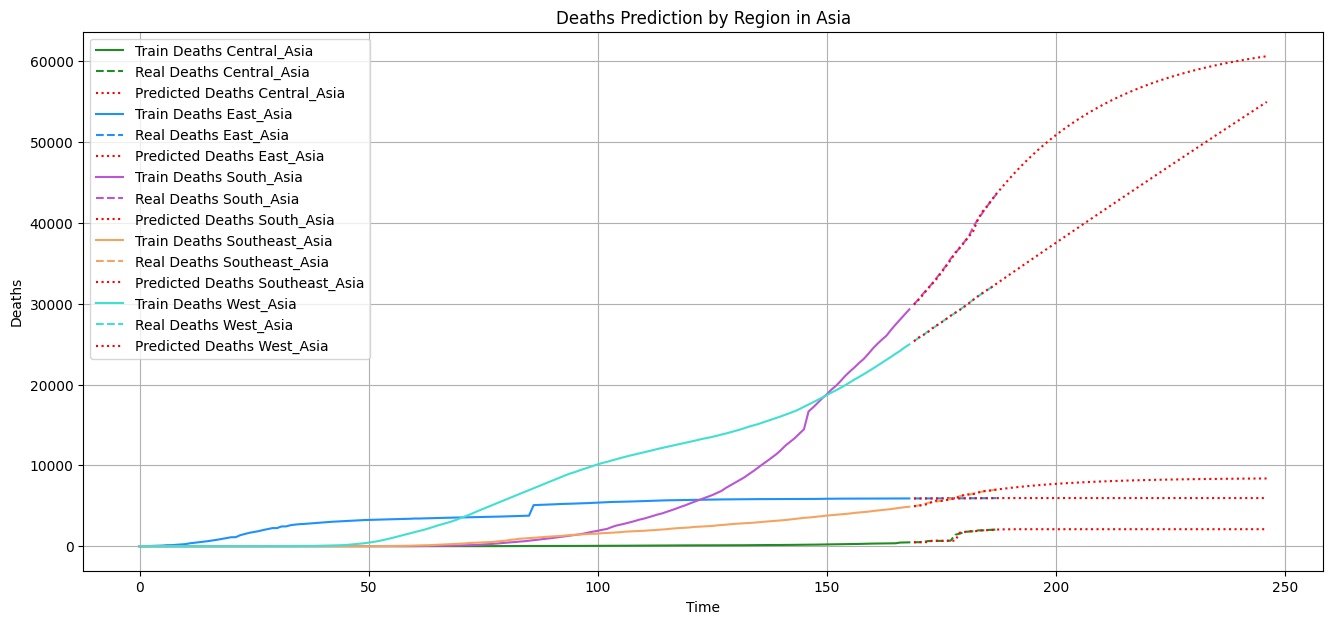

In [ ]:
colors = ['forestgreen', 'dodgerblue', 'mediumorchid', 'sandybrown', 'turquoise']
plt.figure(figsize=(16,7))
plt.xlabel('Time')
plt.ylabel('Deaths')
plt.grid(True)
for region, color in zip(asia_regions.keys(),colors):
  exec(f"train_data, test_data = data_{region}[0:int(len(data_{region})*0.9)], data_{region}[int(len(data_{region})*0.9):]")

  train_arima = list(train_data['Deaths'])
  test_arima = list(test_data['Deaths'])

  history_deaths = [x for x in train_arima]
  y = test_arima
  # make first prediction
  predictions = list()
  model = ARIMA(history_deaths, order=(2,1,0))
  model_fit = model.fit()
  yhat = model_fit.forecast()[0]
  predictions.append(yhat)
  history_deaths.append(y[0])

  # rolling forecasts
  for i in range(1, len(y)+59):
      # predict
      model = ARIMA(history_deaths, order=(2,1,0))
      model_fit = model.fit()
      yhat = model_fit.forecast()[0]
      predictions.append(yhat)
      try:
        obs = y[i]
        history_deaths.append(obs)
      except:
        history_deaths.append(yhat)

  time_line = pd.RangeIndex(start=test_data.index[0], stop=test_data.index[-1]+60, step=1)
    # # Plot the training data
  exec(f"plt.plot(data_{region}.index[:len(train_arima)], data_{region}['Deaths'][:len(train_arima)], color=color, label = 'Train Deaths {region}')")
    # # Plot the test data
  exec(f"plt.plot(test_data.index, y, color = color, label = 'Real Deaths {region}', linestyle='dashed')")
    # # Plot the predictions
  exec(f"plt.plot(time_line, predictions, color = 'red', label = 'Predicted Deaths {region}',linestyle='dotted')")

plt.title('Deaths Prediction by Region in Asia')
plt.savefig('Deaths Prediction by Region in Asia.pdf')
plt.legend()
plt.show()


## ARIMA for confirmed cases

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


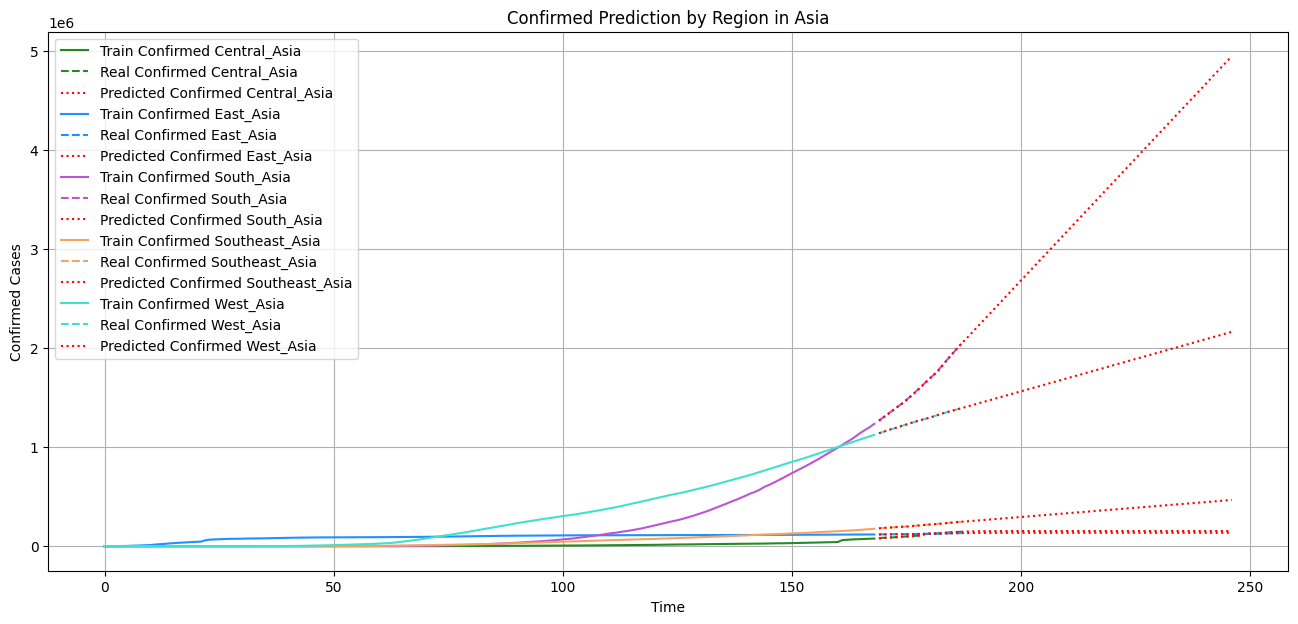

In [ ]:
colors = ['forestgreen', 'dodgerblue', 'mediumorchid', 'sandybrown', 'turquoise']
plt.figure(figsize=(16,7))
plt.xlabel('Time')
plt.ylabel('Confirmed Cases')
plt.grid(True)
for region, color in zip(asia_regions.keys(),colors):
  #print(region)

  exec(f"train_data, test_data = data_{region}[0:int(len(data_{region})*0.9)], data_{region}[int(len(data_{region})*0.9):]")

  train_arima = list(train_data['Confirmed'])
  test_arima = list(test_data['Confirmed'])

  history_confirmed = [x for x in train_arima]
  y = test_arima
  # make first prediction
  predictions = list()
  model = ARIMA(history_confirmed, order=(2,1,0))
  model_fit = model.fit()
  yhat = model_fit.forecast()[0]
  predictions.append(yhat)
  history_confirmed.append(y[0])

  # rolling forecasts
  for i in range(1, len(y)+59):
      # predict
      model = ARIMA(history_confirmed, order=(2,1,0))
      model_fit = model.fit()
      yhat = model_fit.forecast()[0]
      predictions.append(yhat)
      try:
        obs = y[i]
        history_confirmed.append(obs)
      except:
        history_confirmed.append(yhat)



  time_line = pd.RangeIndex(start=test_data.index[0], stop=test_data.index[-1]+60, step=1)

  exec(f"plt.plot(data_{region}.index[:len(train_arima)], data_{region}['Confirmed'][:len(train_arima)], color=color, label = 'Train Confirmed {region}')")
  exec(f"plt.plot(test_data.index, y, color = color, label = 'Real Confirmed {region}', linestyle='dashed')")
  exec(f"plt.plot(time_line, predictions, color = 'red', label = 'Predicted Confirmed {region}',linestyle='dotted')")

plt.title('Confirmed Prediction by Region in Asia')
plt.savefig('Confirmed Prediction by Region in Asia.pdf')
plt.legend()
plt.show()


## ARIMA for mortality rate



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


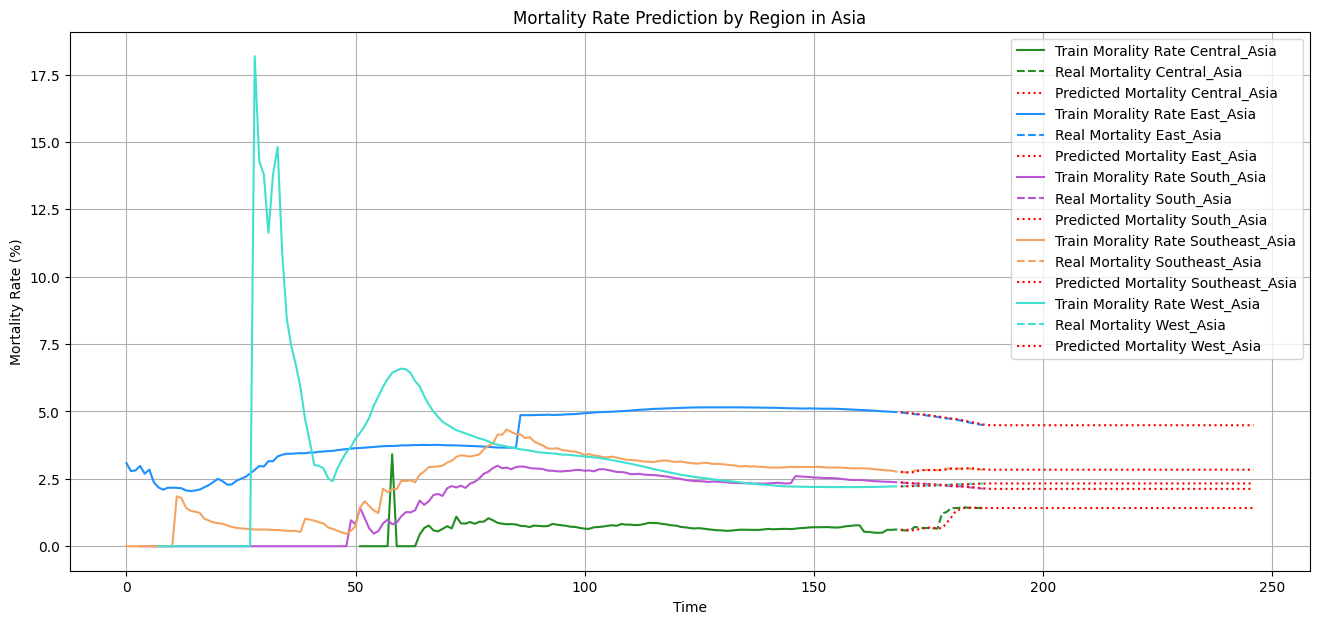

In [ ]:
colors = ['forestgreen', 'dodgerblue', 'mediumorchid', 'sandybrown', 'turquoise']
plt.figure(figsize=(16,7))
plt.xlabel('Time')
plt.ylabel('Mortality Rate (%)')
plt.grid(True)
for region, color in zip(asia_regions.keys(),colors):

  exec(f"train_data, test_data = data_{region}[0:int(len(data_{region})*0.9)], data_{region}[int(len(data_{region})*0.9):]")

  train_arima = list(train_data['Deaths']/train_data['Confirmed']*100)
  test_arima = list(test_data['Deaths']/test_data['Confirmed']*100)

  history_mor_rate = [x for x in train_arima]
  y = test_arima
  # make first prediction
  predictions = list()
  model = ARIMA(history_mor_rate, order=(2,1,0))
  model_fit = model.fit()
  yhat = model_fit.forecast()[0]
  predictions.append(yhat)
  history_mor_rate.append(y[0])

  # rolling forecasts
  for i in range(1, len(y)+59):
      # predict
      model = ARIMA(history_mor_rate, order=(2,1,0))
      model_fit = model.fit()
      yhat = model_fit.forecast()[0]
      predictions.append(yhat)
      try:
        obs = y[i]
        history_mor_rate.append(obs)
      except:
        history_mor_rate.append(yhat)


  time_line = pd.RangeIndex(start=test_data.index[0], stop=test_data.index[-1]+60, step=1)



  exec(f"plt.plot(data_{region}.index[:len(train_arima)], train_arima, color=color, label = 'Train Morality Rate {region}')")
  exec(f"plt.plot(test_data.index, y, color = color, label = 'Real Mortality {region}', linestyle='dashed')")
  exec(f"plt.plot(time_line, predictions, color = 'red', label = 'Predicted Mortality {region}',linestyle='dotted')")

plt.title('Mortality Rate Prediction by Region in Asia')
plt.savefig('Mortality Rate Prediction by Region in Asia.pdf')
plt.legend()
plt.show()


The highest peak in West Asia around the end of February was a result of Iran's high mortality rate at that time which made the region's mortality rate to rise drastically

There was a sudden increase in the Mortality East_Asia around the 85th day. It was because [China revised their statistic](https://www.npr.org/sections/coronavirus-live-updates/2020/04/17/836700806/china-raises-wuhan-death-stats-by-half-to-account-for-reporting-delays-and-omiss) to include more death toll in Wuhan



# Individual Countries Analysis

## Creating dataframes for individual countries

The new dataframes would be:
 - data_{country_name} e.g: data_Vietnam, data_South_Korea
 - data_delta_{country_name} e.g: data_delta_China

The data_delta_{} df would include the ***daily*** new confirmed, deaths and Recovered and Active

In [ ]:
df = data_covid_19_clean_complete

# Grouping by 'Country/Region' and 'Date' and aggregating the data
data_covid_19_new = df.groupby(['Country/Region','Date']).agg({
    #'Province/State': 'first',
    'Lat': 'mean',
    'Long': 'mean',
    'Confirmed': 'sum',
    'Deaths': 'sum',
    'Recovered': 'sum',
    'Active': 'sum',
    'WHO Region': 'first'
}).reset_index()


In [ ]:
df = data_covid_19_new
# Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Group by 'Country/Region'
grouped = df.groupby('Country/Region')
# Iterate over groups and create variables dynamically
for country, group in grouped:
    result_df = group.copy()
    result_df.reset_index(drop = True, inplace=True)
    # Replace spaces with underscores in the country name
    country_variable_name = f"data_{country.replace(' ', '_')}"
    # Create variables dynamically using locals()
    locals()[country_variable_name] = result_df

In [ ]:
df = data_covid_19_new

# Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'])


# Group by 'Country/Region'
grouped = df.groupby('Country/Region')

# Iterate over groups and create variables dynamically
for country, group in grouped:
    # Calculate differences only for numeric columns
    numeric_diff_df = group[['Confirmed', 'Deaths', 'Recovered', 'Active']].diff()

    # Rename difference columns
    numeric_diff_df.columns = [f'delta_{col}' for col in numeric_diff_df.columns]

    # Concatenate original categorical values and differences
    result_df = pd.concat([group[['Country/Region', 'Lat', 'Long', 'Date', 'WHO Region']],
                           numeric_diff_df],
                          axis=1)

    # Fill NaN with 0 only for numeric columns
    result_df[['delta_Confirmed', 'delta_Deaths', 'delta_Recovered', 'delta_Active']] = \
        result_df[['delta_Confirmed', 'delta_Deaths', 'delta_Recovered', 'delta_Active']].fillna(0)

    result_df.reset_index(drop = True, inplace=True)
    # Replace spaces with underscores in the country name
    country_variable_name = f"data_delta_{country.replace(' ', '_')}"
    # Create variables dynamically using locals()
    locals()[country_variable_name] = result_df



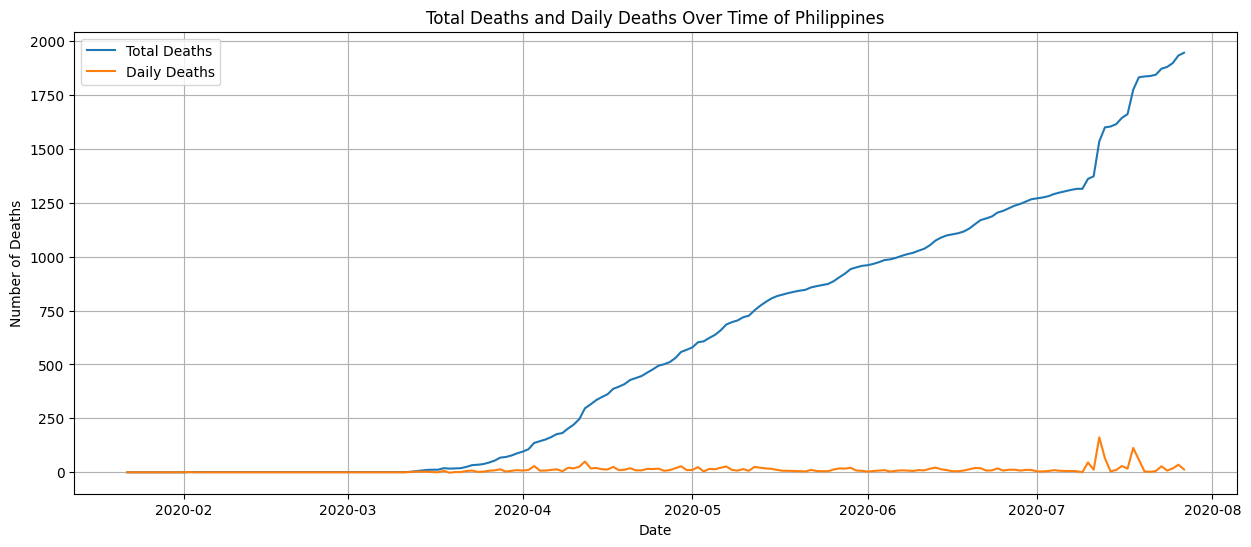

In [ ]:
# Plot original death cases
plt.plot(data_Philippines['Date'], data_Philippines['Deaths'], label='Total Deaths')

# Plot delta_death from the new DataFrame
plt.plot(data_delta_Philippines['Date'], data_delta_Philippines['delta_Deaths'], label='Daily Deaths')

# Customize the plot
plt.title('Total Deaths and Daily Deaths Over Time of Philippines')
plt.xlabel('Date')
plt.ylabel('Number of Deaths')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

country = "Philippines"
exec(f"ori_data = data_{country}")
exec(f"delta_data = data_delta_{country}")

mor_rate = []
history_deaths = ori_data["Deaths"]
history_confirmed = ori_data["Confirmed"]

for i in range(len(history_deaths)):
    if history_confirmed[i] != 0:
        mor_rate.append((history_deaths[i] / history_confirmed[i])*100)
    else:
        mor_rate.append(0)

# Create subplots with shared x-axis and secondary y-axis
fig = make_subplots(rows=1, cols=1, shared_xaxes=True, subplot_titles=[f'Confirmed Cases and Mortality Rate Over Time {country}'],
                    specs=[[{'secondary_y': True}]])

# Add traces to the subplots
fig.add_trace(go.Scatter(x=delta_data['Date'], y=delta_data['delta_Confirmed'],
                         mode='lines', name='Newly Confirmed', line=dict(dash='dot')), row=1, col=1)

fig.add_trace(go.Scatter(x=ori_data['Date'], y=ori_data['Confirmed'],
                         mode='lines', name='Confirmed', line=dict(dash='solid')), row=1, col=1)

# Create a new y-axis for Mortality Rate
fig.add_trace(go.Scatter(x=ori_data['Date'], y=mor_rate,
                         mode='lines', name='Mortality Rate', line=dict(dash='dash')), row=1, col=1, secondary_y=True)

# Update layout to manually set range and dtick for both y-axes
fig.update_layout(
    yaxis=dict(range=[0, max(ori_data['Confirmed'])],
               dtick=max(ori_data['Confirmed'])/10,
               title='Confirmed Cases'),
    yaxis2=dict(
        title='Mortality Rate (%)',
        range=[0, max(mor_rate)],
        # dtick=0.1,
        side='right'),
    xaxis=dict(title='Date')
)

# Show the plot
fig.show()


In [ ]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

country = "Philippines"
exec(f"ori_data = data_{country}")
exec(f"delta_data = data_delta_{country}")

mor_rate = []
history_deaths = ori_data["Deaths"]
history_confirmed = ori_data["Confirmed"]

for i in range(len(history_deaths)):
    if history_confirmed[i] != 0:
        mor_rate.append((history_deaths[i] / history_confirmed[i])*100)
    else:
        mor_rate.append(0)

# Create subplots with shared x-axis and secondary y-axis
fig = make_subplots(rows=1, cols=1, shared_xaxes=True, subplot_titles=[f'Newly Confirmed cases and Mortality Rate Over Time {country}'],
                    specs=[[{'secondary_y': True}]])

# Add traces to the subplots
fig.add_trace(go.Scatter(x=delta_data['Date'], y=delta_data['delta_Confirmed'],
                         mode='lines', name='Newly Confirmed cases', line=dict(dash='dot')), row=1, col=1)


# Create a new y-axis for Mortality Rate
fig.add_trace(go.Scatter(x=ori_data['Date'], y=mor_rate,
                         mode='lines', name='Mortality Rate', line=dict(dash='dash')), row=1, col=1, secondary_y=True)

# Update layout to manually set range and dtick for both y-axes
fig.update_layout(
    yaxis=dict(range=[0, max(delta_data['delta_Confirmed'])], dtick=max(delta_data['delta_Confirmed'])/10, title = 'Newly Confirmed Cases'),
    yaxis2=dict(
        title='Mortality Rate (%)',
        #range=[0, 1],
        #dtick=0.1,
        side='right'),
    xaxis=dict(title='Date')

)

# Show the plot
fig.show()
